# **Siamese Neural Networks for One-shot Image Recognition**

Koch, G., Zemel, R., & Salakhutdinov, R. (2015, July). Siamese neural networks for one-shot image recognition. In ICML deep learning workshop (Vol. 2).

## **Default Settings**

In [22]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

print(f"tf.__version__: {tf.__version__}")
print(f"tfds.__version__: {tfds.__version__}")

tf.__version__: 2.4.1
tfds.__version__: 4.0.1


## **Load Dataset**

In [33]:
## Get dataset as a dictionary of merged numpy.
tr_dict = tfds.as_numpy(tfds.load(
    "omniglot", 
    split = "train", 
    batch_size = -1))

ts_dict = tfds.as_numpy(tfds.load(
    "omniglot", 
    split = "test", 
    batch_size = -1))

## Print the shapes.
print("Training dictionary...")
for key, value in tr_dict.items():
    print(f" - {key}.shape: {value.shape}")

print("\nTest dictionary...")
for key, value in ts_dict.items():
    print(f" - {key}.shape: {value.shape}")

Training dictionary...
 - alphabet.shape: (19280,)
 - alphabet_char_id.shape: (19280,)
 - image.shape: (19280, 105, 105, 3)
 - label.shape: (19280,)

Test dictionary...
 - alphabet.shape: (13180,)
 - alphabet_char_id.shape: (13180,)
 - image.shape: (13180, 105, 105, 3)
 - label.shape: (13180,)


## **Create Model**

In [ ]:
def create_NN(
    model_name
):
    IMAGE_SIZE = [105, 105]

    def Conv_ReLU_MaxPool(
        x,
        filters,
        kernel_size,
        strides = 1,
        padding = "valid",
        apply_pooling = True,
        pool_size = 2,
    ):
        x = tf.keras.layers.Conv2D(filters, kernel_size, strides = strides, padding = padding)(x)
        x = tf.keras.layers.ReLU()(x)
        
        if apply_pooling:
            x = tf.keras.layers.MaxPool2D(pool_size)(x)

        return x


    def create_siamese_NN(
        embedding_size = 4096,
    ):
        x = model_input = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 1), dtype = tf.dtypes.float32)

        x = Conv_ReLU_MaxPool(x, 64, 10)
        x = Conv_ReLU_MaxPool(x, 128, 7)
        x = Conv_ReLU_MaxPool(x, 128, 4)
        x = Conv_ReLU_MaxPool(x, 256, 4, apply_pooling = False)

        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(embedding_size)(x)
        model_output = x = tf.keras.layers.Activation(tf.nn.sigmoid)(x)

        return tf.keras.Model(
            inputs = model_input,
            outputs = model_output)


    x_1 = model_input_1 = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 1), dtype = tf.dtypes.float32)
    x_2 = model_input_2 = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 1), dtype = tf.dtypes.float32)

    siamese_model = create_siamese_NN()

    x_1 = siamese_model(x_1)
    x_2 = siamese_model(x_2)

    ## Calculate l1 siamese distance.
    x = tf.keras.layers.Subtract()([x_1, x_2])
    x = tf.keras.layers.Lambda(lambda x: tf.linalg.normalize(x, ord = 1)[0], name = "l1_normalize")(x)

    ## No activation in the final layer according to the paper.
    x = tf.keras.layers.Dense(1, use_bias = False)(x)

    model_output = x = tf.keras.layers.Activation(tf.nn.sigmoid)(x)

    return tf.keras.Model(
        inputs = [model_input_1, model_input_2],
        outputs = model_output,
        name = model_name)

In [ ]:
tmp = create_NN("tmp")
tmp.summary()

Model: "tmp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
model_12 (Functional)           (None, 4096)         38947648    input_29[0][0]                   
                                                                 input_30[0][0]                   
__________________________________________________________________________________________________
subtract_6 (Subtract)           (None, 4096)         0           model_12[0][0]                 

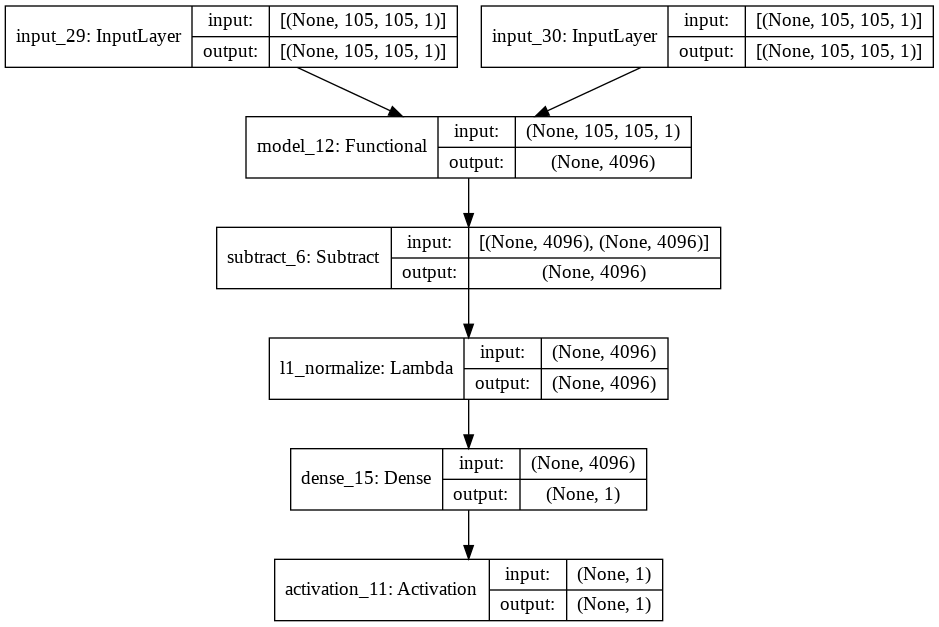

In [ ]:
tf.keras.utils.plot_model(tmp, show_shapes = True)

In [ ]:
del tmp